## 비용 함수 이해하기
###### One-variable linear Regression Model 활용
###### 파라미터와 cost 변화 시각화
###### 임의의 loss function 선언, 임베딩 변화 시각화, loss 조작

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
import random
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from celluloid import Camera
from IPython.display import HTML
from tqdm.auto import tqdm

plt.style.use('ggplot')

In [3]:
# Pseudo data generation
m = 20
w_true = 0.5
x = np.linspace(-1, 1, m)
y = w_true * x

x_ts = torch.tensor(x)
y_ts = torch.tensor(y)

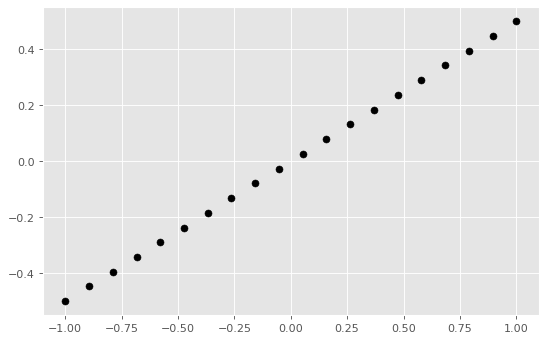

In [4]:
plt.figure(figsize=(8, 5), dpi=80)
plt.scatter(x, y, marker='o', s=40, color='k')

In [5]:
# cost function으로 MSE 사용
def costfunc(y_gold, y_pred):
    losses = torch.pow((y_gold - y_pred), 2)
    return torch.mean(losses)

class Model(nn.Module):
    
    def __init__(self, n_feature=1):
        super().__init__()
        # 가중치 설정 (변량 1개, random normal distribution)
        self.weight = nn.Parameter(torch.randn(n_feature))
        
    def forward(self, x, custom_w=None):
        if custom_w is not None: y_pred = x * custom_w
        else: y_pred = x * self.weight
        # 차원 조정
        y_pred = y_pred.flatten()
        return y_pred        

In [6]:
model = Model(n_feature=1)
optimizer = optim.SGD(model.parameters(), lr=0.4)
n_iter = 5

In [7]:
# 모델 학습에 따른 변화 확인
cmap = plt.get_cmap('coolwarm')
c_norm = colors.Normalize(vmin=0, vmax=n_iter)
scalar_map = cmx.ScalarMappable(norm=c_norm, cmap=cmap)

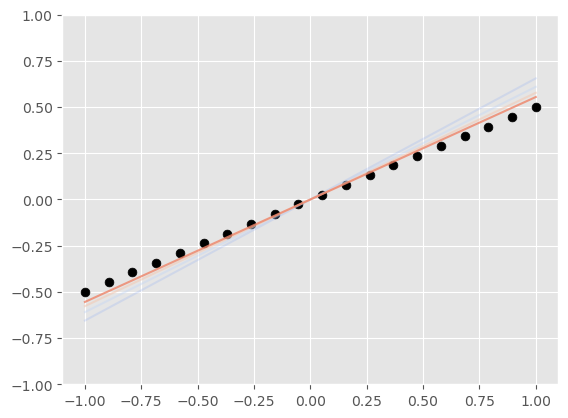

In [8]:
plt.ylim(-1, 1)
plt.scatter(x, y, marker='o', s=40, color='k')

cost_list = []
w_list = []

for step in range(n_iter):
    optimizer.zero_grad()
    y_pred = model(x_ts.view(-1, 1))
    cost = costfunc(y_ts, y_pred)
    
    cost_list.append(cost.item())
    w_list.append(model.weight.item())
    
    cost.backward()
    optimizer.step()
    
    plt.plot(x_ts.detach().numpy(), y_pred.detach().numpy(), alpha=step/n_iter, color=scalar_map.to_rgba(step))

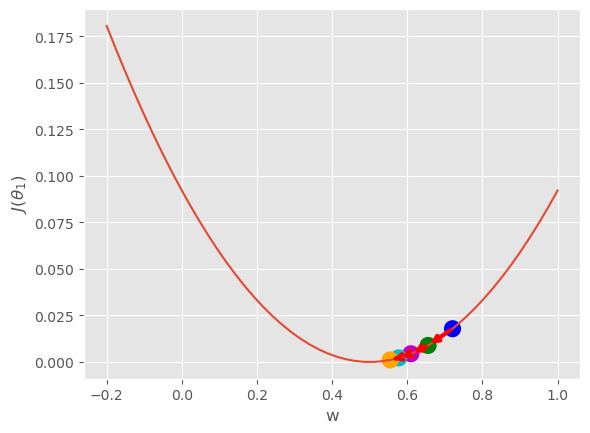

In [9]:
w_grid = np.linspace(-0.2, 1., 50)
cost_grid = []
color_list = ['b', 'g', 'm', 'c', 'orange']

for w in w_grid:
    cost_grid.append(costfunc(y_ts, model(x_ts.view(-1, 1), torch.tensor(w).view(-1, 1))).item())
plt.plot(w_grid, cost_grid)

plt.ylabel(r'$J(\theta_1)$')
plt.xlabel(r'w')

for j in range(1, len(w_list)):
    plt.annotate(
        '', 
        xy=(w_list[j], cost_list[j]), 
        xytext=(w_list[j-1], cost_list[j-1]),
        arrowprops={'arrowstyle' : '->', 'color' : 'r', 'lw' : 3},
        va='center',
        ha='center'
    )
plt.scatter(w_list, cost_list, c=color_list, s=40, lw=6)


###### 학습에 따른 가중치 변화와 cost 감소를 확인할 수 있다

## 손실 함수 핸들링

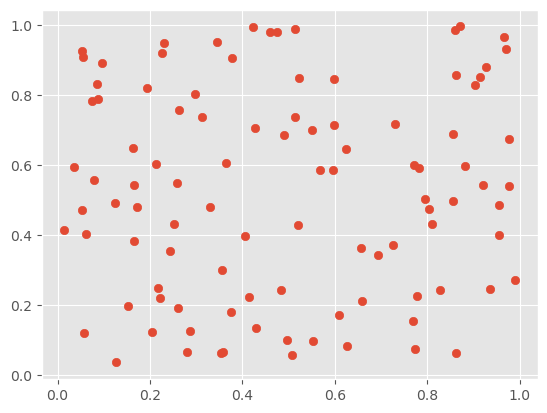

In [10]:
n = 100
dim = 2
vecs = torch.nn.Parameter(torch.rand(n, dim, dtype=torch.float))
plt.scatter([x for x, _ in vecs.detach().numpy()], [y for _, y in vecs.detach().numpy()])

In [11]:
optimizer = optim.Adam([vecs], lr=0.005)
pbar = tqdm(range(1000))

fig, ax = plt.subplots(figsize=(8, 8))
camera = Camera(fig)

for step in pbar:
    optimizer.zero_grad()
    batch = vecs
    unit_loss = torch.mean(torch.pow(torch.sum(torch.pow(batch, 2), dim=1) - 1., 2))
    centroid_loss = torch.sum(torch.pow(torch.mean(batch, dim=0), 2))
    
    loss = unit_loss + centroid_loss
    pbar.set_description(f'loss: {loss:0.4f}, unit_loss: {unit_loss:0.4f}, centroid_loss: {centroid_loss:0.4f}')
    
    loss.backward()
    optimizer.step()
    
    if step % 20 == 0:
        v = vecs.detach().numpy()
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.scatter([x for x, _ in v], [y for _, y in v], color='k')
        camera.snap()
plt.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [12]:
animation = camera.animate(interval=100, repeat=True)
animation.save('loss.gif')

MovieWriter ffmpeg unavailable; using Pillow instead.
